In [3]:
import glob
filename = glob.glob(r'../../dataset/FineTuning/train/ABNORMAL/*.*')
print(len(filename))
filename = glob.glob(r'../../dataset/FineTuning/train/NORMAL/*.*')
print(len(filename))

1214
4203


In [4]:
import datetime
import time

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing  import image_dataset_from_directory
from tensorflow.keras.layers import Input,UpSampling3D,Dense, Dropout,BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,Conv2DTranspose, Concatenate,concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import layers

Init Plugin
Init Graph Optimizer
Init Kernel


In [6]:
train_dir = '../../dataset/FineTuning/train/'
BATCH_SIZE = 16
IMG_SIZE = (256, 256)


In [7]:
train_dataset = image_dataset_from_directory(
    train_dir, 
    shuffle=True,
    validation_split=0.2,
    seed=123,
    label_mode='categorical',
    subset='training',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=IMG_SIZE)

val_dataset = image_dataset_from_directory(
    train_dir,
    validation_split=0.1,
    label_mode='categorical',
    subset="validation",
    seed=123,
    color_mode='rgb',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)
test_dataset = image_dataset_from_directory(
    train_dir,
    validation_split=0.1,
    label_mode='categorical',
    subset="validation",
    seed=123,
    color_mode='rgb',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 5417 files belonging to 2 classes.
Using 4334 files for training.
Metal device set to: Apple M1


Error processing line 1 of /Users/user/miniforge3/envs/Apple/lib/python3.9/site-packages/matplotlib-nspkg.pth:

  Traceback (most recent call last):
    File "/Users/user/miniforge3/envs/Apple/lib/python3.9/site.py", line 169, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 562, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored
2022-06-13 08:59:45.182536: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-13 08:59:45.182746: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 5417 files belonging to 2 classes.
Using 541 files for validation.
Found 5417 files belonging to 2 classes.
Using 541 files for validation.


In [8]:
class_names = train_dataset.class_names
print(class_names)
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 10))
# for images, labels in val_dataset.take(1):
#     print(labels)
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"),cmap='gray')
#         plt.title(class_names[labels[i]])
#         plt.axis("off")

['ABNORMAL', 'NORMAL']


In [9]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of train batches: 271
Number of validation batches: 34
Number of test batches: 34


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)



In [11]:
def build_model(input_shape):
    inputs = Input(shape=input_shape, name="input_image")
    mobilenetv2 = tf.keras.applications.MobileNetV2(
        input_tensor = inputs, 
        weights="imagenet", include_top=False, alpha=0.35)
    
    x = mobilenetv2.get_layer('out_relu').output
    x = Dropout(0.25)(x)
    x = Conv2D(128,3,name='final_conv',padding='same',activation='relu')(x)
    x = GlobalAveragePooling2D(name='gap')(x)
    output = Dense(2,activation='softmax')(x)
    return tf.keras.Model(inputs,output)

In [12]:
model = build_model(input_shape=(256,256,3))
model.load_weights('../../output/checkpoints/mobilenetv2/512_128weights.16-0.31.hdf5')

model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])
model.summary()   

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 16) 432         input_image[0][0]                
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 16) 64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 128, 128, 16) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [13]:
log_dir = "logs/finetune/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callback = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.1, patience=3, verbose=1, min_lr=1e-7 ),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='../../output/checkpoints/finetune_weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        save_best_only=True,save_weights_only=True,verbose=1)
           ]

2022-06-13 08:59:46.789625: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-13 08:59:46.789651: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-13 08:59:46.790319: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


In [12]:
history = model.fit(train_dataset,
                    initial_epoch=0,
                    epochs=20,
                    validation_data=val_dataset,
                   callbacks=callback)

/Users/user/miniforge3/envs/Apple/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-06-11 08:30:53.004763: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-11 08:30:53.012169: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-11 08:30:53.012417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


  2/271 [..............................] - ETA: 58s - loss: 0.7042 - accuracy: 0.8125  

2022-06-11 08:30:54.448077: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-06-11 08:30:54.448089: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-06-11 08:30:54.619339: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-11 08:30:54.620922: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-06-11 08:30:54.623083: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/finetune/20220611-083051/train/plugins/profile/2022_06_11_08_30_54
2022-06-11 08:30:54.625166: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/finetune/20220611-083051/train/plugins/profile/2022_06_11_08_30_54/users-MBP.trace.json.gz
2022-06-11 08:30:54.626606: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/finetune/20220611-083051/t

271/271 [==============================] - ETA: 0s - loss: 0.4516 - accuracy: 0.8461WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x280702c10> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-06-11 08:31:38.459892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


271/271 [==============================] - 50s 175ms/step - loss: 0.4516 - accuracy: 0.8461 - val_loss: 0.2819 - val_accuracy: 0.8614

Epoch 00001: val_loss improved from inf to 0.28185, saving model to ../../output/checkpoints/finetune_weights.01-0.28.hdf5
Epoch 2/20
271/271 [==============================] - 47s 173ms/step - loss: 0.2313 - accuracy: 0.9017 - val_loss: 0.2151 - val_accuracy: 0.8891

Epoch 00002: val_loss improved from 0.28185 to 0.21513, saving model to ../../output/checkpoints/finetune_weights.02-0.22.hdf5
Epoch 3/20
271/271 [==============================] - 48s 173ms/step - loss: 0.1713 - accuracy: 0.9347 - val_loss: 0.1684 - val_accuracy: 0.9279

Epoch 00003: val_loss improved from 0.21513 to 0.16838, saving model to ../../output/checkpoints/finetune_weights.03-0.17.hdf5
Epoch 4/20
271/271 [==============================] - 47s 173ms/step - loss: 0.1379 - accuracy: 0.9462 - val_loss: 0.1512 - val_accuracy: 0.9409

Epoch 00004: val_loss improved from 0.16838 to 0.1

In [14]:
model.load_weights('../../output/checkpoints/finetune_weights.08-0.12.hdf5')
model.evaluate(test_dataset)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-06-13 08:59:54.398511: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-13 08:59:54.402782: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-13 08:59:54.403382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - 4s 75ms/step - loss: 0.1231 - accuracy: 0.9612


[0.1231001690030098, 0.9611830115318298]

In [15]:
y = []
x = []

for image,label in  test_dataset.take(34):
    for l in label:
        y.append(l)
    for im in image:
        x.append(im)

In [16]:
import numpy as np
y = np.array(y)
x = np.array(x)
print(y.shape,x.shape)

(541, 2) (541, 256, 256, 3)


In [17]:
predictions = model.predict(x)
predictions = predictions.reshape(541,2)



Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-06-13 09:00:02.786416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [18]:
predictions = [int(xx[0]<xx[1]) for xx in predictions]
y = [int(yy[0]<yy[1]) for yy in y]

In [19]:
import pandas as pd
df = pd.DataFrame({'ytrue':y,'pred':predictions})
df['ytrue'].value_counts()

1    432
0    109
Name: ytrue, dtype: int64

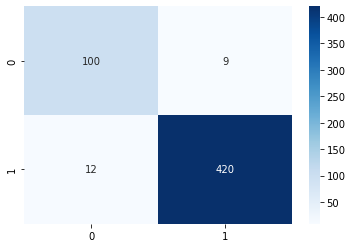

In [20]:
import seaborn as sns
cm = tf.math.confusion_matrix(y,predictions)
ax = sns.heatmap(cm, annot=True, fmt='', cmap='Blues')

In [43]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_cam_heatmap(img_array,model, layer_name,cam_path="cam.jpg"):
    
        #Get the 128 input weights to the softmax.
        class_weights = model.layers[-1].get_weights()[0]

        get_output = K.function(
            [model.input], 
            [model.get_layer(layer_name).output, model.output])
        
        [conv_outputs, predictions] = get_output([img_array])
        conv_outputs = conv_outputs[0, :, :, :]
        
        #Create the class activation map.
        cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
        
        for i,w in enumerate(class_weights[:, 0]):
            cam += w * conv_outputs[:, :, i]
            
        cam = tf.maximum(cam, 0) / tf.math.reduce_max(cam)

        return cam.numpy()

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    grads=grads[0,:,:,:]

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
#     heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.math.multiply(last_conv_layer_output,grads)
    heatmap = tf.reduce_sum(heatmap,axis=-1)
#     heatmap = tf.keras.layers.ctivation.sigmoid()(heatmap)

    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def grad_cam_plus_heatmap(img,model, layer_name="final_conv", label_name=None,
                  category_id=None):
    """Get a heatmap by Grad-CAM++.
    Args:
        model: A model object, build from tf.keras 2.X.
        img: An image ndarray.
        layer_name: A string, layer name in model.
        label_name: A list or None,
            show the label name by assign this argument,
            it should be a list of all label names.
        category_id: An integer, index of the class.
            Default is the category with the highest score in the prediction.
    Return:
        A heatmap ndarray(without color).
    """
    img_tensor = np.expand_dims(img, axis=0)

    conv_layer = model.get_layer(layer_name)
    heatmap_model =  tf.keras.models.Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape1:
        with tf.GradientTape() as gtape2:
            with tf.GradientTape() as gtape3:
                conv_output, predictions = heatmap_model(img)
                if category_id==None:
                    category_id = np.argmax(predictions[0])
                if label_name:
                    print(label_name[category_id])
                output = predictions[:, category_id]
                conv_first_grad = gtape3.gradient(output, conv_output)
            conv_second_grad = gtape2.gradient(conv_first_grad, conv_output)
        conv_third_grad = gtape1.gradient(conv_second_grad, conv_output)

    global_sum = np.sum(conv_output, axis=(0, 1, 2))

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)
    
    alphas = alpha_num/alpha_denom
    alpha_normalization_constant = np.sum(alphas, axis=(0,1))
    alphas /= alpha_normalization_constant

    weights = np.maximum(conv_first_grad[0], 0.0)

    deep_linearization_weights = np.sum(weights*alphas, axis=(0,1))
    grad_CAM_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)

    heatmap = np.maximum(grad_CAM_map, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    return heatmap

def ScoreCam(model, img_array, layer_name, max_N=-1):

    cls = np.argmax(model.predict(img_array))
    act_map_array = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(layer_name).output).predict(img_array)
    
    # extract effective maps
    if max_N != -1:
        act_map_std_list = [np.std(act_map_array[0,:,:,k]) for k in range(act_map_array.shape[3])]
        unsorted_max_indices = np.argpartition(-np.array(act_map_std_list), max_N)[:max_N]
        max_N_indices = unsorted_max_indices[np.argsort(-np.array(act_map_std_list)[unsorted_max_indices])]
        act_map_array = act_map_array[:,:,:,max_N_indices]

    input_shape = model.layers[0].output_shape[0][1:]  # get input shape
    # 1. upsample to original input size
    act_map_resized_list = [cv2.resize(act_map_array[0,:,:,k], input_shape[:2], interpolation=cv2.INTER_LINEAR) for k in range(act_map_array.shape[3])]
    # 2. normalize the raw activation value in each activation map into [0, 1]
    act_map_normalized_list = []
    for act_map_resized in act_map_resized_list:
        if np.max(act_map_resized) - np.min(act_map_resized) != 0:
            act_map_normalized = act_map_resized / (np.max(act_map_resized) - np.min(act_map_resized))
        else:
            act_map_normalized = act_map_resized
        act_map_normalized_list.append(act_map_normalized)
    # 3. project highlighted area in the activation map to original input space by multiplying the normalized activation map
    masked_input_list = []
    for act_map_normalized in act_map_normalized_list:
        masked_input = np.copy(img_array)
        for k in range(3):
            masked_input[0,:,:,k] *= act_map_normalized
        masked_input_list.append(masked_input)
    masked_input_array = np.concatenate(masked_input_list, axis=0)
    # 4. feed masked inputs into CNN model and softmax
    pred_from_masked_input_array = softmax(model.predict(masked_input_array))
    # 5. define weight as the score of target class
    weights = pred_from_masked_input_array[:,cls]
    # 6. get final class discriminative localization map as linear weighted combination of all activation maps
    cam = np.dot(act_map_array[0,:,:,:], weights)
    cam = np.maximum(0, cam)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0
    
    return cam

def softmax(x):
    f = np.exp(x)/np.sum(np.exp(x), axis = 1, keepdims = True)
    return f

In [44]:
def save_and_display_gradcam(img, heatmap, pos, cam_path="cam.jpg", alpha=0.4,title='input'):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:,:3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    plt.subplot(5,2,pos)
    plt.title(title)
    plt.imshow(superimposed_img)


In [45]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [46]:
import glob
import cv2
filename = glob.glob('../../dataset/FineTuning/train/ABNORMAL/*.*')
len(filename)

1214

In [58]:
input_image = []
for images,l in test_dataset.take(34):
    for im in images:
        input_image.append(np.reshape(im,(1,256,256,3)))
        
        

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-06-13 09:43:24.114373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-06-13 09:43:25.195525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-06-13 09:43:26.374297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-06-13 09:43:27.445075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-06-13 09:43:28.599356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


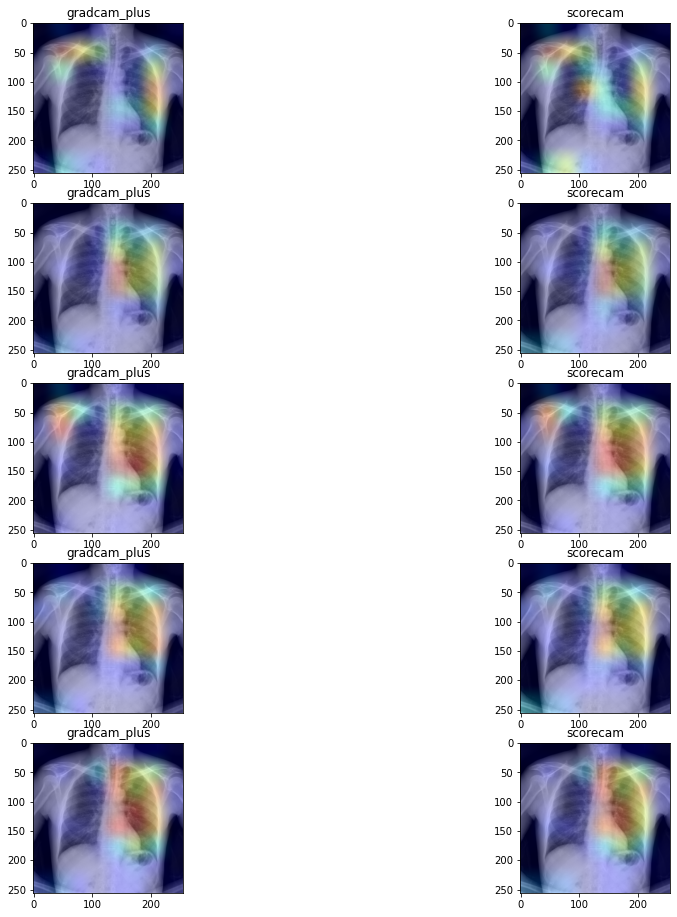

In [62]:
plt.figure(figsize=(16, 16))
i=0
for count in range(1,6):
    i+=1
    img = input_image[count]
    model.predict(img)
    
    heatmap_cam = make_cam_heatmap(img, model, 'final_conv')
    heatmap_gradcam = make_gradcam_heatmap(img, model, 'final_conv')
    heatmap_grad_plus = grad_cam_plus_heatmap(img, model, layer_name="final_conv")
    heatmap_score_cam = ScoreCam(model, img, 'final_conv', max_N=-1)
#     save_and_display_gradcam(im, heatmap_gradcam,2*i-1,title='gradcam')
    save_and_display_gradcam(im, heatmap_score_cam,2*i,title='scorecam')
    save_and_display_gradcam(im, heatmap_grad_plus,2*i-1,title='gradcam_plus')
#     save_and_display_gradcam(im, heatmap_cam,2*i,title='cam')
    

model limitation
hyperparameter improvement 
data size/quality 